In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import glob

def showResponseMap(all_ISJs, trial_len_ms, prestim_len_ms, samp_interval, 
                    NDIRS=8, tick_interval_ms=250, f_ax=None, show_xlabels=True):
    if f_ax is None:
        f, ax = plt.subplots(1,1)
    else:
        f, ax = f_ax

    ax.imshow(all_ISJs, cmap='hot', aspect=8)
    ax.set_xticks(range(0,all_ISJs.shape[1],tick_interval_ms//samp_interval))
    if show_xlabels:
        ax.set_xticklabels(np.arange(-prestim_len_ms,trial_len_ms,tick_interval_ms, dtype='int'))
        ax.set_xlabel('trial time (ms)', size=8)
    else:
        ax.set_xticklabels(['']*len(ax.get_xticks()))
        
    
    ax.set(yticks=range(NDIRS), yticklabels=['' for _ in range(NDIRS)])
    ax.set_ylabel('direction', size=8)
    
    ax.tick_params(labelsize=8)
    f.tight_layout()
    return f, ax

def checkStimSignificance(stim_stats, maxPvalThresh, METHOD='MANNWHITNEY', minFRthresh=0., debug=False):
    
    is_sig = False
    
    pmaxtype = 'maxinterval-pval'
    #check if maxinterval is signif for at least one dir
    dirs = stim_stats[pmaxtype].keys()
    
    minpval,minpvalFR = np.inf, None #keep track of lowest pval and corresp. FR
    
    sig_dirs = [] #keep track of which directions are significant
    for d in dirs:
        # try:
        pval = stim_stats[pmaxtype][d][METHOD]
        fr = stim_stats[pmaxtype][d]['stimFR']

        if pval <= maxPvalThresh:
            sig_dirs.append(d)
        if pval < minpval:
            minpval = pval
            minpvalFR = fr
            best_d = d
    if debug:
        print(f"(dir {best_d}): minpval={minpval:.2e}, minpvalFR={minpvalFR:.2f}" + \
                f" vs. isiFR={stim_stats[pmaxtype][best_d]['isiFR']:.2f}",end=': ')    
    


    if minpval <= maxPvalThresh and fr >= minFRthresh:
        if debug: print('sig!')
        is_sig = True
    else: 
        #instead, check if min-interval is signif for all dirs           
        #use as pval the most restrictive (max), i.e., should be signif for all dirs
        max_minint_pval = max([stim_stats['mininterval-pval'][d][METHOD] for d in dirs])
        
        if max_minint_pval <= maxPvalThresh:#SIG
            if debug: print(f'sig ISI (maxmin={max_minint_pval:.2e}')
            is_sig = True
   
    return is_sig

### Compute significant stimuli for each unit

In [4]:
#load spike data files
datadir = 'data'

STIM_CLASS = 'drifting_gratings'
AREA = 'VISl'
bw = 25
maxPvalThresh = 1e-3

significant_stims = {}
cell_ids_to_use = []
stims_to_use = [1.0, 2.0, 4.0, 8.0, 15.0]

# get spike time files from all sessions for this area and stim 
filenames = sorted(glob.glob(f'{datadir}/*{AREA}_{STIM_CLASS}_bw{bw}.pkl'))
    
for fname in filenames:
    # parse session id from filename
    session_id = fname.split('/')[-1].split('_')[0] 
    print(session_id)
    
    with open(fname,'rb') as f:
        datadict = pickle.load(f)
    if len(datadict) == 0:
        continue
        
        
    significant_stims[session_id] = {}
    
    for uid in sorted(datadict):
        skip_cell = False
        cell_dict = datadict[uid]
        sig_stims = []
        for si,stim in enumerate(stims_to_use):
            if stim not in cell_dict: #all selected stims must be rpesernt
                skip_cell = True
                break
            stim_stats = cell_dict[stim]['stats']
            is_sig = checkStimSignificance(stim_stats,maxPvalThresh, debug=False)
            if is_sig:
                sig_stims.append(si)
            
        if not sig_stims or skip_cell:
            continue
            
        significant_stims[session_id][uid] = sig_stims
        cell_ids_to_use.append((session_id,uid))
print(len(significant_stims),'exps')

s715093703
s719161530
s721123822
s732592105
s737581020
s739448407
s742951821
s743475441
s744228101
s746083955
s750332458
s750749662
s751348571
s754312389
s754829445
s755434585
s756029989
s757216464
s757970808
s758798717
s759883607
s760345702
s760693773
s761418226
s762120172
s762602078
s763673393
s773418906
s791319847
s797828357
s798911424
s799864342
32 exps


In [5]:

# normalize each response to prevent biasing the decomposition toward sustained responses or cells with higher FRs
normalize_responses = True

# keep a list of statistically significant stims for each cell (done above)
# (non-signif. responses will be zeroed-out for now to reduce noise and help tensor decomposition)


#keep track of which cell ids and stims were actually used in the tensor
cells_stims_used = []
all_zeroed_stims = {}
# also make note of original max FRs for each stim
cell_maxFRs = []


# Use the same values here that were used when reading the spikes from the Allen dataset
NDIRS = 8
tot_trial_len_ms = 2250
samp_interval = 10
PSTLEN = tot_trial_len_ms//samp_interval
response_len = NDIRS * PSTLEN

# build two versions of the tensor:
# one containing statistically significant responses only...
sigT = np.zeros((len(cell_ids_to_use), len(stims_to_use), response_len))
# ...and another containing all original responses
allT = np.zeros((len(cell_ids_to_use), len(stims_to_use), response_len))

curr_session_id = None
#for each cell
for ci,(session_id,cell_id) in enumerate(cell_ids_to_use):
    
    if session_id != curr_session_id:
        #load data file
        print(session_id)
        if bw is None:
            fname = f'{session_id}_{AREA}_{STIM_CLASS}.pkl'
        else:
            fname = f'{session_id}_{AREA}_{STIM_CLASS}_bw{bw}.pkl'
        with open(f'{datadir}/{fname}','rb') as f:
            datadict = pickle.load(f)
        curr_session_id = session_id
            
    sig_stims_used = []
    zeroed_stims = []
    stim_maxFRs = []

    for si,sname in enumerate(stims_to_use):
        
        assert significant_stims[session_id][cell_id] #every cell used must have at least one signif response
        
        response_map = datadict[cell_id][sname]['psts']
        assert response_map.shape[0] == NDIRS
        response_map = response_map[:,:PSTLEN]

        
        # flatten response map before adding to tensor
        res = response_map.ravel(order='F')# use Fortran order (colwise) for later use with matlab
        
        stim_maxFRs.append(res.max())
        
        if normalize_responses:
            norm = np.linalg.norm(res)
            if norm > 0:
                res /= norm
          
        allT[ci,si] = res
        
        if si in significant_stims[session_id][cell_id]:
            sigT[ci,si] = res
            sig_stims_used.append(si)
        else:
            zeroed_stims.append(si)
        
    cells_stims_used.append((cell_id,sig_stims_used))
    cell_maxFRs.append(np.array(stim_maxFRs))
    if zeroed_stims:
        all_zeroed_stims[ci] = tuple(zeroed_stims)
            
sigT.shape

s715093703
s719161530
s721123822
s732592105
s737581020
s739448407
s742951821
s743475441
s744228101
s746083955
s750332458
s750749662
s751348571
s754312389
s754829445
s755434585
s756029989
s757216464
s757970808
s758798717
s759883607
s760345702
s760693773
s761418226
s762120172
s762602078
s763673393
s773418906
s791319847
s797828357
s798911424
s799864342


(1362, 5, 1800)

In [10]:
METHOD = 'shiftdirs'
minNfactors = 2
maxNfactors = 40
nReps = 20
rep0 = 0
nShifts = NDIRS
mytensorname = f"{STIM_CLASS}_{AREA}_{METHOD}_p{maxPvalThresh}{'_bw%d' % bw if bw else ''}_{len(significant_stims)}xp_N{sigT.shape[0]}"
print(mytensorname)


drifting_gratings_VISp_shiftdirs_p0.001_bw25_32xp_N1362


In [12]:
# Save all files

datadir = 'tensor-data'
np.save(f'{datadir}/{mytensorname}_sigT.npy',sigT)
np.save(f'{datadir}/{mytensorname}_allT.npy',allT)
np.save(f'{datadir}/{mytensorname}_cell_maxFRs.npy',cell_maxFRs)
with open(f'{datadir}/{mytensorname}_all_zeroed_stims.pkl','wb') as f:
    pickle.dump(all_zeroed_stims,f)

with open(f'{datadir}/{mytensorname}_significant_stims.pkl','wb') as f:
    pickle.dump(significant_stims,f)    

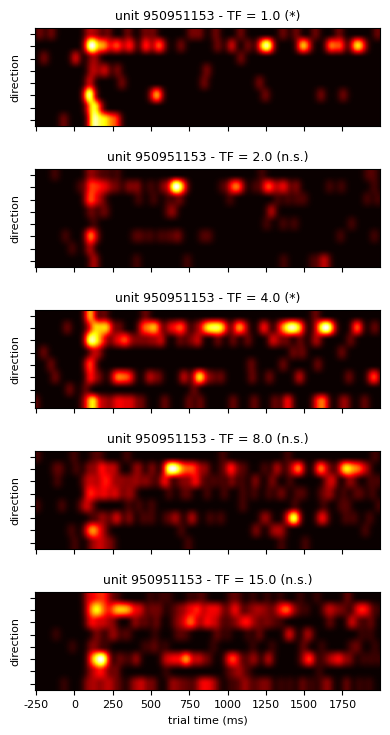

In [27]:
# Visualize a cell and check which stimuli 
cell_i = 0

uid, sig_stims = cells_stims_used[cell_i]
samp_interval = 10
NDIRS = 8
trial_len_ms = 2000
prestim_len_ms = 250
samp_interval = 10


f, axes = plt.subplots(len(stims_to_use),1,figsize=(4,1.5*len(stims_to_use)))
for si,sname in enumerate(stims_to_use):
    ax = axes[si]
    showResponseMap(allT[cell_i][si].reshape(NDIRS,-1,order='F'), 
                    trial_len_ms, prestim_len_ms, samp_interval,
                    f_ax=(f,ax), show_xlabels=(si == len(stims_to_use)-1))
    sig_str = '*' if si in sig_stims else 'n.s.'
    ax.set_title(f'unit {uid} - TF = {sname} ({sig_str})', size=9);
f.tight_layout()
plt.show()

### Save Allen pre-computed metrics

In [22]:
datadir = 'data'
with open(f'{datadir}/{mytensorname}_significant_stims.pkl','rb') as f:
    significant_stims = pickle.load(f)

In [3]:
import pandas as pd
# Example cache directory path, it determines where downloaded data will be stored
cache_dir = 'ecephys_cache_dir/'

import os
# this path determines where downloaded data will be stored
manifest_path = os.path.join(cache_dir, "manifest.json")
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [15]:

#https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/80/75/8075a100-ca64-429a-b39a-569121b612b2/neuropixels_visual_coding_-_white_paper_v10.pdf
mycols = ['firing_rate_dg', 'g_dsi_dg', 'g_osi_dg',  
          'pref_tf_dg', 'mod_idx_dg', 'pref_sf_sg', 'pref_ori_dg',
            'run_mod_dg', 'run_pval_dg', 'firing_rate_sg', 'firing_rate_ns',
          'pref_image_ns', 'image_selectivity_ns',  
          'area_rf', 'p_value_rf', 'firing_rate_rf', 'f1_f0_dg',
         ]


datadir = 'tensor-data'
with open(f'{datadir}/{mytensorname}_significant_stims.pkl','rb') as f:
    significant_stims = pickle.load(f)

df = None
for session_id in significant_stims:
    print(session_id, end=' ')
    session_uids = list(significant_stims[session_id].keys())
    session_int = int(session_id[1:])
    metrics = cache.get_unit_analysis_metrics_for_session(session_int).loc[session_uids][mycols]
    if df is None:
        df = metrics.copy()
    else:
        df = pd.concat([df, metrics])
print(df.shape)

datadir = 'tensor-data'
with open(f'{datadir}/{mytensorname}_metrics_df.pkl','wb') as f:
    pickle.dump(df,f)

s715093703 s719161530 s721123822 s732592105 s737581020 s739448407 s742951821 s743475441 s744228101 s746083955 s750332458 s750749662 s751348571 s754312389 s754829445 s755434585 s756029989 s757216464 s757970808 s758798717 s759883607 s760345702 s760693773 s761418226 s762120172 s762602078 s763673393 s773418906 s791319847 s797828357 s798911424 s799864342 (1362, 17)


### Load layer info and save data specific to units in this dataset

In [11]:
with open('all_layer_info.pkl','rb') as f:
    all_layer_info = pickle.load(f)

lyrinfo = []
depthinfo = []
for session_id in significant_stims:
    print(session_id, end=' ')
    session_uids = list(significant_stims[session_id].keys())
    session_int = int(session_id[1:])
    for uid in session_uids:
        if uid in all_layer_info[session_int]:
            layer = all_layer_info[session_int][uid]['cortical_layer']
            depth = all_layer_info[session_int][uid]['cortical_depth']
        else:
            layer, depth = 0, 0
        lyrinfo.append( layer )
        depthinfo.append( depth )
datadir = 'tensor-data'
fname = f'{datadir}/{mytensorname}_layers.npy'
np.save(fname,np.array(lyrinfo))    
fname = f'{datadir}/{mytensorname}_depths.npy'
np.save(fname,np.array(depthinfo))    

s715093703 s719161530 s721123822 s732592105 s737581020 s739448407 s742951821 s743475441 s744228101 s746083955 s750332458 s750749662 s751348571 s754312389 s754829445 s755434585 s756029989 s757216464 s757970808 s758798717 s759883607 s760345702 s760693773 s761418226 s762120172 s762602078 s763673393 s773418906 s791319847 s797828357 s798911424 s799864342 